# Intent Classification using LSTM with GloVe Embeddings

This notebook implements an LSTM-based intent classification model using pre-trained GloVe word embeddings for customer support intent classification.

## 1. Import Required Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from collections import Counter

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Load and Explore Data

In [48]:
# Load datasets
train_df = pd.read_csv('../Data/Bitext_Sample_Customer_Service_Training_Dataset.csv')
val_df = pd.read_csv('../Data/Bitext_Sample_Customer_Service_Validation_Dataset.csv')
test_df = pd.read_csv('../Data/Bitext_Sample_Customer_Service_Testing_Dataset.csv')

print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Testing data shape:", test_df.shape)
print("\nNumber of unique intents:", train_df['intent'].nunique())
print("\nSample data:")
print(train_df.head())

Training data shape: (6539, 4)
Validation data shape: (818, 4)
Testing data shape: (818, 4)

Number of unique intents: 27

Sample data:
                                           utterance        intent category  \
0   would it be possible to cancel the order I made?  cancel_order    ORDER   
1                                   cancelling order  cancel_order    ORDER   
2  I need assistance canceling the last order I h...  cancel_order    ORDER   
3            problem with canceling the order I made  cancel_order    ORDER   
4        I don't know how to cancel the order I made  cancel_order    ORDER   

  tags  
0  BIP  
1   BK  
2    B  
3    B  
4    B  


## 3. Text Preprocessing

In [49]:
def clean_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
train_df['cleaned_utterance'] = train_df['utterance'].apply(clean_text)
val_df['cleaned_utterance'] = val_df['utterance'].apply(clean_text)
test_df['cleaned_utterance'] = test_df['utterance'].apply(clean_text)

print("Sample cleaned utterances:")
for i in range(3):
    print(f"Original: {train_df['utterance'].iloc[i]}")
    print(f"Cleaned:  {train_df['cleaned_utterance'].iloc[i]}")
    print()

Sample cleaned utterances:
Original: would it be possible to cancel the order I made?
Cleaned:  would it be possible to cancel the order i made

Original: cancelling order
Cleaned:  cancelling order

Original: I need assistance canceling the last order I have made
Cleaned:  i need assistance canceling the last order i have made



## 4. Tokenization and Sequence Preparation

In [50]:
# Tokenize the text
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_SEQUENCE_LENGTH = 20  # Maximum length of sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_utterance'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['cleaned_utterance'])
X_val = tokenizer.texts_to_sequences(val_df['cleaned_utterance'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_utterance'])

# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Training sequences shape: {X_train.shape}")
print(f"Validation sequences shape: {X_val.shape}")
print(f"Testing sequences shape: {X_test.shape}")
print(f"\nSample sequence: {X_train[5]}")
print(f"Original text: {train_df['cleaned_utterance'].iloc[5]}")

Vocabulary size: 647
Training sequences shape: (6539, 20)
Validation sequences shape: (818, 20)
Testing sequences shape: (818, 20)

Sample sequence: [10 16  5  9 75  4 19  2 71  0  0  0  0  0  0  0  0  0  0  0]
Original text: can you help me cancel the order i made


## 5. Label Encoding

In [51]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['intent'])
y_val_encoded = label_encoder.transform(val_df['intent'])
y_test_encoded = label_encoder.transform(test_df['intent'])

# Convert to categorical (one-hot encoding)
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_val = to_categorical(y_val_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Number of classes: {num_classes}")
print(f"Training labels shape: {y_train.shape}")
print(f"Sample intent mapping:")
for i in range(5):
    print(f"  {label_encoder.classes_[i]} -> {i}")

Number of classes: 27
Training labels shape: (6539, 27)
Sample intent mapping:
  cancel_order -> 0
  change_order -> 1
  change_shipping_address -> 2
  check_cancellation_fee -> 3
  check_invoice -> 4


## 6. Download and Load GloVe Embeddings

We'll use pre-trained GloVe embeddings (100-dimensional). If you don't have them, place the file manually.

In [52]:
import os

# GloVe settings
EMBEDDING_DIM = 100
GLOVE_DIR = '../Data/glove'
GLOVE_FILE = f'glove.6B.{EMBEDDING_DIM}d.txt'
GLOVE_PATH = os.path.join(GLOVE_DIR, GLOVE_FILE)

# Create directory if it doesn't exist
os.makedirs(GLOVE_DIR, exist_ok=True)

# Check if GloVe file exists
if os.path.exists(GLOVE_PATH):
    print(f"✓ GloVe embeddings found at: {GLOVE_PATH}")
    print(f"  File size: {os.path.getsize(GLOVE_PATH) / (1024*1024):.2f} MB")

✓ GloVe embeddings found at: ../Data/glove/glove.6B.100d.txt
  File size: 331.04 MB


## 7. Create Embedding Matrix

In [54]:
# Load GloVe embeddings
print("Loading GloVe embeddings...")
embeddings_index = {}

with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")

# Create embedding matrix
vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

words_found = 0
for word, i in tokenizer.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector
        words_found += 1
    else:
        print(f"Word not found in GloVe: {word}")
        

print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Words found in GloVe: {words_found}/{vocab_size} ({100*words_found/vocab_size:.2f}%)")

Loading GloVe embeddings...
Loaded 400000 word vectors.
Word not found in GloVe: <OOV>
Word not found in GloVe: uhelp
Word not found in GloVe: unsubscribing
Word not found in GloVe: uare
Word not found in GloVe: asistance
Word not found in GloVe: hwat
Word not found in GloVe: needhelp
Word not found in GloVe: cannott
Word not found in GloVe: avaqilable
Word not found in GloVe: cutomer
Word not found in GloVe: ehlp
Word not found in GloVe: addresxs
Word not found in GloVe: uupdatte
Word not found in GloVe: updatng
Word not found in GloVe: havesubmitted
Word not found in GloVe: addrses
Word not found in GloVe: nede
Word not found in GloVe: corrdct
Word not found in GloVe: thedelivery
Word not found in GloVe: knlw
Word not found in GloVe: uchange
Word not found in GloVe: upodate
Word not found in GloVe: cancellationcharge
Word not found in GloVe: feees
Word not found in GloVe: cancllation
Word not found in GloVe: termniation
Word not found in GloVe: cancellatino
Word not found in GloVe: c

## 8. Build LSTM Model with GloVe Embeddings

In [55]:
def create_lstm_model(vocab_size, embedding_dim, max_length, num_classes, embedding_matrix):
    """
    Create a Bidirectional LSTM model with pre-trained GloVe embeddings
    """
    model = Sequential([
        # Embedding layer with pre-trained GloVe weights
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=True  # Allow fine-tuning of embeddings
        ),
        
        # Bidirectional LSTM layer
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        
        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_lstm_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix
)

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │        64,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,700 (252.73 KB)

 Trainable params: 64,700 (252.73 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Compile the Model

In [56]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


## 10. Setup Training Callbacks

In [57]:
# Create directory for saving models
MODEL_DIR = '../models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save the best model
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_lstm_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured successfully!")

Callbacks configured successfully!


## 11. Train the Model

In [58]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 50

print("Starting training...")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}\n")

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Training samples: 6539
Validation samples: 818
Batch size: 32
Max epochs: 50

Epoch 1/50
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2168 - loss: 2.6685
Epoch 1: val_accuracy improved from None to 0.90465, saving model to ../models/best_lstm_model.h5

Epoch 1: val_accuracy improved from None to 0.90465, saving model to ../models/best_lstm_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4556 - loss: 1.8010 - val_accuracy: 0.9046 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8706 - loss: 0.4390
Epoch 2: val_accuracy improved from 0.90465 to 0.96088, saving model to ../models/best_lstm_model.h5

Epoch 2: val_accuracy improved from 0.90465 to 0.96088, saving model to ../models/best_lstm_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8998 - loss: 0.3381 - val_accuracy: 0.9609 - val_loss: 0.1092 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9423 - loss: 0.2024
Epoch 3: val_accuracy improved from 0.96088 to 0.99144, saving model to ../models/best_lstm_model.h5

Epoch 3: val_accuracy improved from 0.96088 to 0.99144, saving model to ../models/best_lstm_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9601 - loss: 0.1526 - val_accuracy: 0.9914 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9845 - loss: 0.0745
Epoch 4: val_accuracy did not improve from 0.99144
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9821 - loss: 0.0811 - val_accuracy: 0.9890 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.99144
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9821 - loss: 0.0811 - val_accuracy: 0.9890 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9777 - loss: 0.0928
Epoch 5: val_accuracy did not improve from 0.99144
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9827 - loss: 0.0783 - val_accuracy: 0.9890 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 6/50

Epoch 5: val_accuracy did not improve from 0.99144
205/205 ━━━━━━━━━━━

205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9910 - loss: 0.0404 - val_accuracy: 0.9951 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 7/50
Epoch 7/50
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9898 - loss: 0.0383
Epoch 7: val_accuracy did not improve from 0.99511
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9881 - loss: 0.0462 - val_accuracy: 0.9951 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.99511
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9881 - loss: 0.0462 - val_accuracy: 0.9951 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9943 - loss: 0.0293
Epoch 8: val_accuracy improved from 0.99511 to 0.99633, saving model to ../models/best_lstm_model.h5

Epoch 8: val_accuracy improved from 0.99511 to 0.99633, saving model to ../models/best_lstm_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9927 - loss: 0.0351 - val_accuracy: 0.9963 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 9/50
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9951 - loss: 0.0211
Epoch 9: val_accuracy did not improve from 0.99633
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9960 - loss: 0.0195 - val_accuracy: 0.9927 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 10/50

Epoch 9: val_accuracy did not improve from 0.99633
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9960 - loss: 0.0195 - val_accuracy: 0.9927 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 10/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9980 - loss: 0.0108
Epoch 10: val_accuracy did not improve from 0.99633

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9986 - loss: 0.0092 - val_accuracy: 0.9927 - val_loss: 0.0293 - learning_rate: 0.0010
E

## 12. Visualize Training History

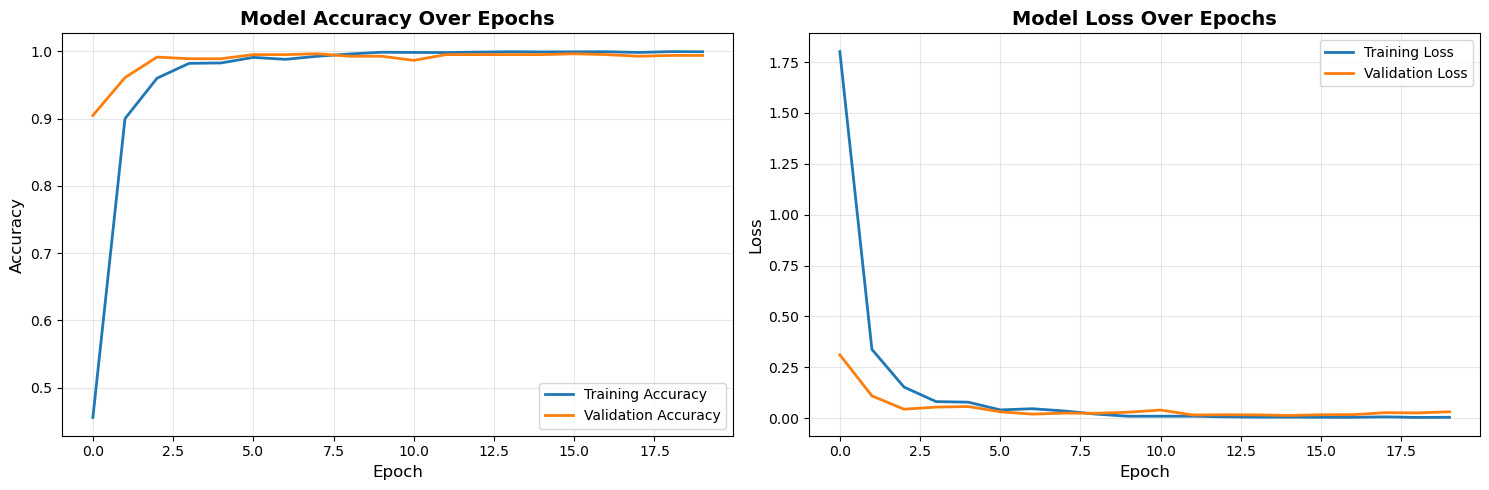


Best Validation Accuracy: 0.9963 at epoch 8
Best Validation Loss: 0.0247


In [59]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f} at epoch {best_epoch + 1}")
print(f"Best Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")

## 13. Evaluate on Test Set

In [66]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*50}")

Evaluating on test set...

Test Accuracy: 0.9914 (99.14%)
Test Loss: 0.0720


## 14. Detailed Classification Report

In [67]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print("="*80)
report = classification_report(
    y_test_classes, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
)
print(report)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Classification Report:
                          precision    recall  f1-score   support

            cancel_order     1.0000    0.9600    0.9796        25
            change_order     0.9750    1.0000    0.9873        39
 change_shipping_address     1.0000    0.9756    0.9877        41
  check_cancellation_fee     1.0000    1.0000    1.0000        26
           check_invoice     1.0000    1.0000    1.0000        31
   check_payment_methods     1.0000    1.0000    1.0000        26
     check_refund_policy     1.0000    1.0000    1.0000        37
               complaint     1.0000    1.0000    1.0000        23
contact_customer_service     0.9600    1.0000    0.9796        24
     contact_human_agent     1.0000    1.0000    1.0000        42
          create_account     1.0000    0.8800    0.9362        25
          delete_account     0.9355    1.0000    0.9667        29
        delivery_options     1.0000    1.0000    1.0000        32
         de

## 16. Test Predictions on Sample Utterances

In [72]:
def predict_intent(text, model, tokenizer, label_encoder, max_length=20):
    """
    Predict intent for a given text
    """
    # Clean and preprocess
    cleaned_text = clean_text(text)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class]
    
    predicted_intent = label_encoder.classes_[predicted_class]
    
    return predicted_intent, confidence

# Test on sample utterances
test_utterances = [
    "I want to remove the order I placed",
    "I want to cancel my order",
    "How can I track my shipment?",
    "I need to change my shipping address",
    "What is my account balance?",
    "I forgot my password, can you help?",
    "Where is my refund?",
    "I want to speak to a human agent",
    "How do I create a new account?" ,
    "someone call me",
    "cancel "
    ]

print("Sample Predictions:")
print("="*80)
for utterance in test_utterances:
    intent, confidence = predict_intent(utterance, model, tokenizer, label_encoder, MAX_SEQUENCE_LENGTH)
    print(f"Text: {utterance}")
    print(f"Predicted Intent: {intent}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print("-"*80)

Sample Predictions:
Text: I want to remove the order I placed
Predicted Intent: change_order
Confidence: 0.9997 (99.97%)
--------------------------------------------------------------------------------
Text: I want to cancel my order
Predicted Intent: cancel_order
Confidence: 1.0000 (100.00%)
--------------------------------------------------------------------------------
Text: How can I track my shipment?
Predicted Intent: track_order
Confidence: 0.8324 (83.24%)
--------------------------------------------------------------------------------
Text: I need to change my shipping address
Predicted Intent: change_shipping_address
Confidence: 1.0000 (100.00%)
--------------------------------------------------------------------------------
Text: What is my account balance?
Predicted Intent: recover_password
Confidence: 0.9997 (99.97%)
--------------------------------------------------------------------------------
Text: I forgot my password, can you help?
Predicted Intent: recover_password
C

## 17. Save Model and Preprocessing Objects

In [69]:
# Save the trained model
model.save(os.path.join(MODEL_DIR, 'lstm_intent_classifier.h5'))
print(f"✓ Model saved to: {os.path.join(MODEL_DIR, 'lstm_intent_classifier.h5')}")

# Save the tokenizer
with open(os.path.join(MODEL_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✓ Tokenizer saved to: {os.path.join(MODEL_DIR, 'tokenizer.pkl')}")

# Save the label encoder
with open(os.path.join(MODEL_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✓ Label encoder saved to: {os.path.join(MODEL_DIR, 'label_encoder.pkl')}")

# Save model configuration
config = {
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'max_words': MAX_WORDS,
    'embedding_dim': EMBEDDING_DIM,
    'num_classes': num_classes,
    'vocab_size': vocab_size
}

with open(os.path.join(MODEL_DIR, 'model_config.pkl'), 'wb') as f:
    pickle.dump(config, f)
print(f"✓ Model config saved to: {os.path.join(MODEL_DIR, 'model_config.pkl')}")

print("\n" + "="*80)
print("All files saved successfully!")
print("="*80)

✓ Model saved to: ../models/lstm_intent_classifier.h5
✓ Tokenizer saved to: ../models/tokenizer.pkl
✓ Label encoder saved to: ../models/label_encoder.pkl
✓ Model config saved to: ../models/model_config.pkl

All files saved successfully!


## 18. Model Summary

**Model Architecture:**
- **Embedding Layer:** Pre-trained GloVe embeddings (100-dimensional, trainable)
- **Bidirectional LSTM:** 2 layers (128 and 64 units)
- **Dropout:** For regularization (0.5 and 0.3)
- **Dense Layers:** 64 units with ReLU activation
- **Output:** Softmax activation for multi-class classification

**Training Configuration:**
- **Optimizer:** Adam
- **Loss Function:** Categorical Crossentropy
- **Callbacks:** Early Stopping, Model Checkpoint, Learning Rate Reduction

**Key Features:**
- ✓ Pre-trained GloVe word embeddings for better word representations
- ✓ Bidirectional LSTM for capturing context from both directions
- ✓ Dropout layers to prevent overfitting
- ✓ Early stopping to avoid overtraining
- ✓ Learning rate reduction for better convergence